<a href="https://colab.research.google.com/github/andvar95/Inteligencia-Artificial/blob/main/Ejemplo_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

Este tutorial usa imágenes de gatos y perros.
Se descarga y extra el archivo ZIP, Se crea un *tf.data.Dataset* para entrenamiento y validación usando *image_dataset_from_directory*


In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dog.zip',origin=_URL,extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'cats_and_dogs_filtered')

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Se muestran las primeras nueve imágenes del dataset

**take** = Return the elements in the given positional indices along an axis.


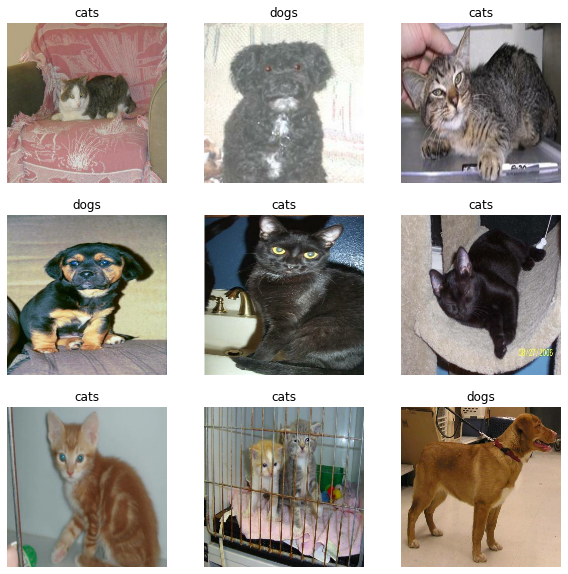

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


No hay un cojunto de prueba por tanto se crea.
Se determina cuantos lotes están disponibles en los datos de validación usando tf.data.experimental.cardinality y el 20% se mueve al conjunto de prueba (test).

**tf.data.experimental.cardinality** : Returns the cardinality of dataset (number of elements)



In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

print("Number of validation batches: %d"%tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches: %d"%tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


Configurar para rendimiento

Se usa la captación anterior por búfer para cargar imágenes desde el disco sin que se bloquee la E/S. 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Se aumenta los datos, ya que se tienen pocos datos por lo que se aplican diversidad artíficial  aplicando a las imágenes efectos como rotación y volteo horizontal.

In [ ]:
data_augmentation = tf.keras.Sequential([
                                          tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                          tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Se prueba en imágenes

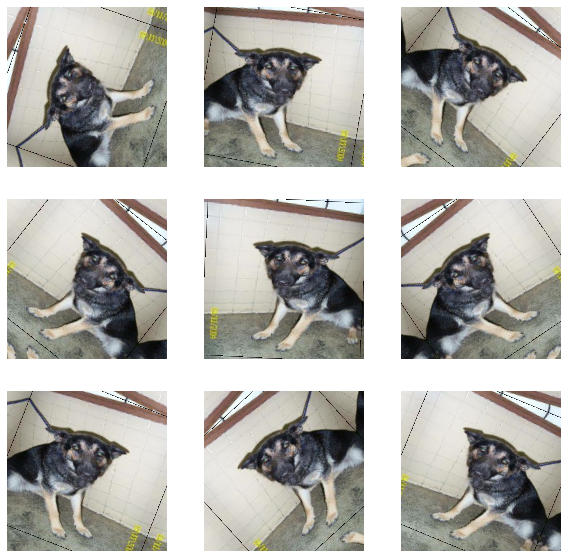

In [ ]:
for image,_ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_im = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_data = data_augmentation(tf.expand_dims(first_im,0))
    plt.imshow(augmented_data[0]/255)
    plt.axis("off")


El modelo a usar es MobilenetV2 este espera datos entre [-1,1] pero se estos están entre [0,255]

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Se crea el modelo MobileNetV2 y se debe elegir que capas usará. Dónde la última capa de clasificación no es muy útil. Es común usar usar la ultima capa antes de aplanar "Capa cuello botella" esta conversa más generalidad que la capa final/superior

Se crea la instancia de MobileNet con sus pesos. el argumento **include_top=False** omite las capas superiores. 

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model =  tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                 include_top= False,
                                                 weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


El extractor de características convierte las imágenes 160x160x3 en una bloque de características d 5x5x1280

In [ ]:
image_batch,label_batch =next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Se congela la base convolucional que se creó anteriormente para luego anexar un clasificador

In [ ]:
base_model.trainable = False

Muchas modelos tiene capas tf.kera.layer.BatchNormalization. Esta capa es una caso especial a observar en el ajust fino

Cuando se establece layers.trainable = False, la capa BatchNormalization  se ejecuta en modo inferencia y no actualiza la media o varianza

Cuando descongela un modelo que contiene capas de BatchNormalization para realizar un ajuste fino, debe mantener las capas de BatchNormalization en modo de inferencia pasando training = False al llamar al modelo base. De lo contrario, las actualizaciones aplicadas a los pesos no entrenables destruirán lo que ha aprendido el modelo.

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Para generar predicciones a partir del bloque de tf.keras.layers.GlobalAveragePooling2D , tf.keras.layers.GlobalAveragePooling2D las ubicaciones espaciales espaciales de 5x5 , utilizando una capa tf.keras.layers.GlobalAveragePooling2D para convertir las tf.keras.layers.GlobalAveragePooling2D en un solo vector de 1280 elementos por imagen.

In [ ]:
global_average_layer =tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique una capa tf.keras.layers.Dense para convertir estas características en una única predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un logit o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [ ]:
prediction_layer =tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Se concatenan las capas de aumento de datos, cambio de escala, base mode y extractor de características

In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))
x=data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x= global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)


Compile el modelo antes de entrenarlo. Dado que hay dos clases, use una pérdida de entropía cruzada binaria con from_logits=True ya que el modelo proporciona una salida lineal.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

Los parámetros de 2.5 M en MobileNetV2 están conmgelados pero 1.2K parametros de la capa Dense están  para ser entrenados 

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
loss0,acc0 = model.evaluate(validation_dataset)

26/26 [==============================] - 12s 480ms/step - loss: 0.8288 - accuracy: 0.4604


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("inital accuracy: {:.2f}.".format(acc0))

initial loss: 0.83
inital accuracy: 0.46.


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 51s 809ms/step - loss: 0.6928 - accuracy: 0.5850 - val_loss: 0.5867 - val_accuracy: 0.6720
Epoch 2/10
63/63 [==============================] - 51s 802ms/step - loss: 0.5336 - accuracy: 0.7095 - val_loss: 0.4386 - val_accuracy: 0.7983
Epoch 3/10
63/63 [==============================] - 51s 803ms/step - loss: 0.4230 - accuracy: 0.7925 - val_loss: 0.3433 - val_accuracy: 0.8589
Epoch 4/10
63/63 [==============================] - 50s 798ms/step - loss: 0.3720 - accuracy: 0.8150 - val_loss: 0.2808 - val_accuracy: 0.8886
Epoch 5/10
63/63 [==============================] - 50s 795ms/step - loss: 0.3169 - accuracy: 0.8560 - val_loss: 0.2317 - val_accuracy: 0.9196
Epoch 6/10
63/63 [==============================] - 50s 800ms/step - loss: 0.2967 - accuracy: 0.8650 - val_loss: 0.2081 - val_accuracy: 0.9270
Epoch 7/10
63/63 [==============================] - 50s 791ms/step - loss: 0.2690 - accuracy: 0.8815 - val_loss: 0.1832 - val_accuracy: 0.9369

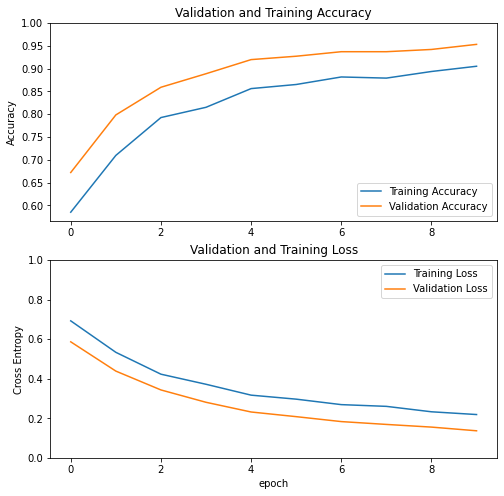

In [ ]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation and Training Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.xlabel('epoch')
plt.title('Validation and Training Loss')
plt.show()


# Sintonia FINA

En el experimento de extracción de características, solo estaba entrenando algunas capas sobre un modelo base de MobileNet V2. Los pesos de la red preentrenada no se actualizaron durante el entrenamiento.

Una forma de aumentar aún más el rendimiento es entrenar (o "ajustar") los pesos de las capas superiores del modelo previamente entrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar los pesos de los mapas de características genéricos a las características asociadas específicamente con el conjunto de datos.

Además, debe intentar ajustar una pequeña cantidad de capas superiores en lugar de todo el modelo de MobileNet. En la mayoría de las redes convolucionales, cuanto más arriba está una capa, más especializada es. Las primeras capas aprenden características muy simples y genéricas que se generalizan a casi todos los tipos de imágenes. A medida que asciende, las características son cada vez más específicas del conjunto de datos en el que se entrenó el modelo. El objetivo del ajuste fino es adaptar estas características especializadas para trabajar con el nuevo conjunto de datos, en lugar de sobrescribir el aprendizaje genérico.

#Descongele las capas superiores del modelo

Todo lo que necesita hacer es descongelar base_model y configurar las capas inferiores para que no se puedan entrenar. Luego, debe volver a compilar el modelo (necesario para que estos cambios surtan efecto) y reanudar el entrenamiento.

In [ ]:
base_model.trainable =  True

In [ ]:
#let's take a look how many layer are in the base model
print("number of layers in the bae model: ", len(base_model.layers))

#fine-tune from this layer onwards(delante)
fine_tune_at = 100

#Froze all layers before *fine_tune_at* layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False



number of layers in the bae model:  155


Se COmpila el modelo, como  es más grande se usa una taza de aprendizaje menor para que no se sobre ajuste rapidamente 

In [ ]:
model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer =tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics = ['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
len(model.trainable_variables)

158

Se entra en modelo 

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs+fine_tune_epochs

history_fine= model.fit(train_dataset,
                   epochs=total_epochs,
                   initial_epoch=history.epoch[-1],
                   validation_data= validation_dataset)

Epoch 10/20
63/63 [==============================] - 142s 2s/step - loss: 0.1126 - accuracy: 0.9540 - val_loss: 0.0417 - val_accuracy: 0.9851
Epoch 11/20
63/63 [==============================] - 142s 2s/step - loss: 0.0923 - accuracy: 0.9620 - val_loss: 0.0338 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 146s 2s/step - loss: 0.0865 - accuracy: 0.9605 - val_loss: 0.0476 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 141s 2s/step - loss: 0.0788 - accuracy: 0.9695 - val_loss: 0.0448 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 141s 2s/step - loss: 0.0692 - accuracy: 0.9710 - val_loss: 0.0354 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 142s 2s/step - loss: 0.0687 - accuracy: 0.9740 - val_loss: 0.0331 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 141s 2s/step - loss: 0.0645 - accuracy: 0.9725 - val_loss: 0.0316 - val_accuracy: 0.9839
Epoch 

Se mira las curvas de precision y perdida de entrenamiento y validación cuando se ajustan las ultimas capas del modelo MobileNetV2 Y se entrena sobre el un clasificador, la perdida de validación es mayor que la de entrenmiento por lo que puede sobreentrenarse el sistema



In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'lower_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'upper_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


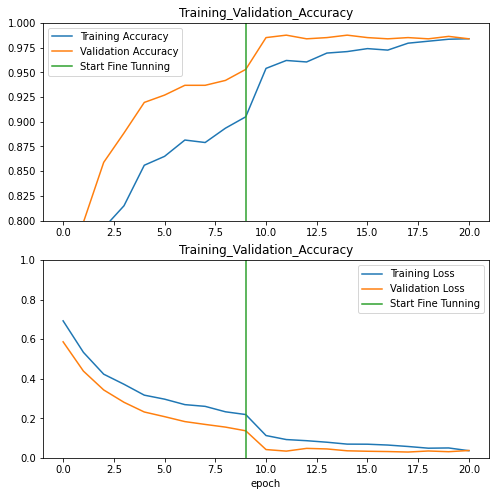

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tunning')
plt.legend(loc='lower_right')
plt.title('Training_Validation_Accuracy')

plt.subplot(2,1,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tunning')
plt.legend(loc='upper_right')
plt.xlabel('epoch')
plt.title('Training_Validation_Accuracy')
plt.show()